In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display
import scipy
from collections import defaultdict

import random

In [3]:
df = pd.read_excel("input.xlsx", sheet_name="test")

In [4]:
dis = display.Display(df=df)
dis.quick_processing()

The columns with prefix  are not in DataFrame
The columns with prefix None are not in DataFrame


In [5]:
df = dis.df

In [6]:
df

,Name,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,...,average_t,right_center_side_t,left_center_side_t,right_side_t,left_side_t,center_t,qul_t,qur_t,qll_t,qlr_t
0,128,1.007261,1.039308,0.780477,0.671881,0.903992,1.340501,1.005525,0.899053,1.312518,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
1,126,1.014851,1.155958,0.936798,0.883959,0.950221,0.804825,1.263511,1.162170,0.763771,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
2,127,1.008279,1.086415,0.837248,0.759608,0.967771,0.790417,1.156539,1.005604,1.361782,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
3,123,0.647791,1.064173,1.098479,1.042141,1.066111,1.027449,0.806435,1.396153,0.931250,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
4,120,0.587420,1.084638,1.229904,0.938634,0.643358,1.204374,1.016986,0.932845,1.086926,...,282.50,286.0,279.0,286.0,279.0,282.5,279.0,286.0,279.0,286.0
5,121,1.142254,1.087766,1.194483,0.851884,0.689963,1.235851,0.941317,0.823667,1.140019,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
6,129,0.717581,0.998936,1.204193,1.014046,0.814873,1.287133,1.022199,0.949048,1.165208,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
7,124_2022.05.23,0.608411,1.049913,1.054652,1.019652,1.040481,0.941543,1.400093,1.321300,0.891886,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
8,123_2022.02.14,0.647791,1.064173,1.098479,1.042141,1.066111,1.027449,0.806435,1.396153,0.931250,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
9,129_end,0.716972,0.997293,1.172891,0.989092,0.817093,1.272100,0.962573,0.896618,1.174517,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0


In [7]:
[i for i in df.columns if "average" in i]

['average_s', 'average_l', 'average_p', 'average_b', 'average_t']

# 1 Generator of cores
## At the momemt only 8th tube FA can be used to generate new core

In [8]:
p_cols = dis.CORE_PARTS["percentage"]["ALL_CELLS"]
t_cols = dis.CORE_PARTS["fuel_type"]["ALL_CELLS"]

In [9]:
ancestor_0 = df.loc[5, :]

In [10]:
ancestor_0[p_cols] = [float("{:.2f}".format(i)) for i in ancestor_0[p_cols].to_numpy() ]

/tmp/ipykernel_29526/3079140421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestor_0[p_cols] = [float("{:.2f}".format(i)) for i in ancestor_0[p_cols].to_numpy() ]
/tmp/ipykernel_29526/3079140421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestor_0[p_cols] = [float("{:.2f}".format(i)) for i in ancestor_0[p_cols].to_numpy() ]


In [11]:
from model import Individual, GA, FITNESS_WEIGHTS_WINDOW, TARGET, Stacking, nonuniformity, NSGAII
from joblib import load, dump

In [12]:
weights = {
    "p_margin": 0.10, # use fuel burnup coef instead of this
    "k_fa_max": 0.10,
    "k_quarter": 0.30, # modify in order to estimate this symmetry more accurate 
    "k_sym": 0.30,
    "k_sided":0.20
}


In [13]:
# ancestor_0["6-6_p"] = 0.0
# ancestor_0["3-6_p"] = 0.0

In [156]:
ga = NSGAII.no_fuel_mask(
    ancestor_0.loc[p_cols].to_numpy(), 
    ancestor_0.loc[t_cols].to_numpy(),
    objective_keys = ["k_sym", "k_quarter", "k_left_right"],
    population_size=150,
    permutation_mutation_probability=0.0,
    mutation_probabilty_fresh_fuel=0.4,
    workers=6
)
indiv = Individual(
    fuel_map=ga.fuel_map,
    dynamic_fuels_gnome_ind=ga.dynamic_fuels_gnome_ind,
    fitness_score_code="nsgaii"
)

In [157]:
ga.ancestor_core

array([3.36, 17.12, 6.52, 48.58, 61.47, 26.51, 51.57, 57.94, 29.39, 36.57,
       3.79, 36.39, 60.9, 47.07, 26.19, 55.19, 41.99, 8.89, 16.64, 47.53],
      dtype=object)

In [158]:
indiv.fitness_score(indiv, *TARGET)

(1.0, 1.0, 1.0, 1.0, 1.0)

In [159]:
ancestor_chromosome = indiv.initialize_chromosome(
    ancestor_0.loc[p_cols].to_numpy(), 
)
ancestor_chromosome

{'id': 'dabce948ed3c4753838a689426375767',
 'fuels_gnome': array([3.36, 17.12, 6.52, 48.58, 61.47, 26.51, 51.57, 57.94, 29.39, 36.57,
        3.79, 36.39, 60.9, 47.07, 26.19, 55.19, 41.99, 8.89, 16.64, 47.53],
       dtype=object),
 'core_burnup': 34.2,
 'p_margin': 0.6436498111314803,
 'k_fa_max': 0.9196152592185975,
 'k_fa_min': 0.670249913129692,
 'k_quarter': 0.9271452723059704,
 'k_sym': 0.7935560435926994,
 'k_left_right': 0.9910707267670071,
 'fitness_score': 0.8835531420381467}

# DO search

In [160]:
for i in range(1,1):
    print(i)

In [161]:
random.seed(42)
trained_population = ga.search(
    generations=100,
    population_score=0.93,
    ind_score=0.95,
    maxtime_limit=600
)
trained_population

start search with populations score: 0.7880935158820677and burnup 34.19999999999999
2x population:  257
257 17 257
[9, 12, 8, 5, 14, 7, 10, 15, 17, 6, 3, 18, 11, 13, 0, 19, 16, 20, 4]
slots left:  19 cd_returned:  19
next_gen_size:  150
average populations score 0.8150549094960368 and burnup 33.22399999999999 at the end of 1 generation
Time taken for iteration:  5.842768430709839
2x population:  238
238 16 238
[2]
slots left:  1 cd_returned:  1
next_gen_size:  150
average populations score 0.832944408578011 and burnup 32.451333333333324 at the end of 2 generation
Time taken for iteration:  4.978330850601196
2x population:  234
234 13 234
[31, 28, 30, 24, 2, 14, 13, 9, 17, 21, 4, 7, 16]
slots left:  13 cd_returned:  13
next_gen_size:  150
average populations score 0.8442200008858797 and burnup 31.719333333333324 at the end of 3 generation
Time taken for iteration:  4.342911720275879
2x population:  230
230 14 230
[9, 15, 5, 13, 12, 21, 1, 23]
slots left:  8 cd_returned:  8
next_gen_size

[{'id': '65d5da39e1cf40cd8c9fd72068d96638',
  'fuels_gnome': array([8.89, 47.53, 17.12, 41.99, 0.0, 26.51, 51.57, 57.94, 29.39, 6.52,
         36.57, 3.36, 0.0, 47.07, 26.19, 55.19, 3.79, 16.64, 48.58, 36.39],
        dtype=object),
  'core_burnup': 28.1,
  'p_margin': 0.9204397077115168,
  'k_fa_max': 0.8016890204307192,
  'k_fa_min': 0.7406537019857069,
  'k_quarter': 0.9871198027142616,
  'k_sym': 0.9077026060530292,
  'k_left_right': 0.9981187230753958,
  'fitness_score': 0.9471059774382248,
  'nb': 0},
 {'id': '332aaef90eb348d984dce265d89873fb',
  'fuels_gnome': array([8.89, 47.53, 17.12, 41.99, 0.0, 26.51, 51.57, 57.94, 29.39, 6.52,
         36.57, 3.36, 0.0, 47.07, 26.19, 55.19, 3.79, 16.64, 48.58, 36.39],
        dtype=object),
  'core_burnup': 28.1,
  'p_margin': 0.9204397077115168,
  'k_fa_max': 0.8016890204307192,
  'k_fa_min': 0.7406537019857069,
  'k_quarter': 0.9871198027142616,
  'k_sym': 0.9077026060530292,
  'k_left_right': 0.9981187230753958,
  'fitness_score': 0.9471

In [162]:
picked = trained_population[0]["fuels_gnome"]
dis.display(picked)

,6,5,4,3
7,8.890000,47.530000,17.120000,41.990000
6,0.000000,26.510000,51.570000,57.940000
5,29.390000,nan,nan,6.520000
4,36.570000,nan,nan,3.360000
3,0.000000,47.070000,26.190000,55.190000
2,3.790000,16.640000,48.580000,36.390000


In [163]:
dis.display(
        Stacking.predict(
            indiv._fuels_gnome_refactorer(indiv, np.asarray(picked)),
            nonuniformity
    ).loc[0, :]*300,
    dt="_s"
)

,6,5,4,3
7,296.777159,234.804062,309.732754,258.224252
6,329.851754,341.382763,266.314747,240.733745
5,314.366376,nan,nan,431.391953
4,301.798392,nan,nan,427.477485
3,332.203002,262.200842,349.582472,237.498090
2,291.504401,293.722675,222.196111,261.111668


In [164]:
fs = [i["fitness_score"] for i in ga._best_per_iter]
fs_aver = [i for i in ga._aver_score_per_iter]

<Axes: >

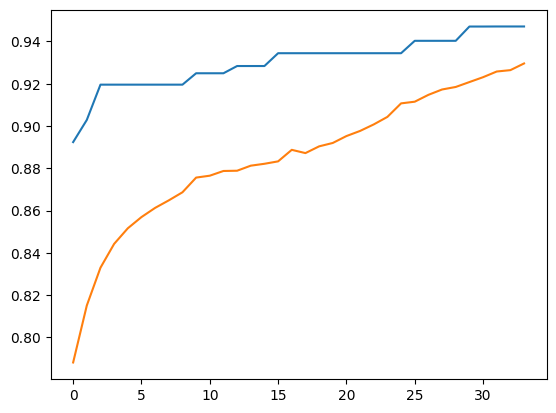

In [165]:
sns.lineplot(fs[:])
sns.lineplot(fs_aver[:])

In [166]:
dump(
    trained_population,
    "trained_population_nsgaii_121_150ps_gen_per_iter_210_10.joblib"
)

['trained_population_nsgaii_121_150ps_gen_per_iter_210_10.joblib']

In [167]:

dump(
    fs,
    f"ga_params_search/121_nsgaii_150ps_gen_per_iter_210_10_best.joblib"
)
dump(
    fs_aver,
    f"ga_params_search/121_nsgaii_150ps_gen_per_iter_210_10_aver.joblib"
)

['ga_params_search/121_nsgaii_150ps_gen_per_iter_210_10_aver.joblib']

In [252]:
gen_results = load("trained_population_129_p_ksym_kquar_300ps.joblib")

In [253]:
gen_results

[{'id': 229,
  'fuels_gnome': array([0.0, 55.78, 6.15, 29.16, 49.83, 14.47, 45.96, 49.94, 23.96, 31.99,
         24.11, 31.76, 49.41, 44.17, 14.43, 48.68, 0.0, 5.98, 55.68, 29.06],
        dtype=object),
  'core_burnup': 30.5,
  'p_margin': 0.8261163840219928,
  'k_fa_max': 1.1095889144706763,
  'k_fa_min': 0.6839080802264021,
  'k_quarter': 0.9553557760654235,
  'k_sym': 0.9699554771810941,
  'k_left_right': 0.9599759253893125,
  'fitness_score': 0.963695031147874},
 {'id': 296,
  'fuels_gnome': array([0.0, 55.78, 6.15, 29.16, 49.83, 14.47, 45.96, 49.94, 23.96, 31.99,
         24.11, 31.76, 49.41, 44.17, 14.43, 48.68, 0.0, 5.98, 55.68, 29.06],
        dtype=object),
  'core_burnup': 30.5,
  'p_margin': 0.8261163840219928,
  'k_fa_max': 1.1095889144706763,
  'k_fa_min': 0.6839080802264021,
  'k_quarter': 0.9553557760654235,
  'k_sym': 0.9699554771810941,
  'k_left_right': 0.9599759253893125,
  'fitness_score': 0.963695031147874},
 {'id': 239,
  'fuels_gnome': array([0.0, 55.68, 5.98, 2

In [254]:
dis.display(gen_results[0]["fuels_gnome"])

,6,5,4,3
7,0.000000,55.780000,6.150000,29.160000
6,49.830000,14.470000,45.960000,49.940000
5,23.960000,nan,nan,31.990000
4,24.110000,nan,nan,31.760000
3,49.410000,44.170000,14.430000,48.680000
2,0.000000,5.980000,55.680000,29.060000


In [255]:
from main import refueling_pattern

In [256]:
gen_results

[{'id': 229,
  'fuels_gnome': array([0.0, 55.78, 6.15, 29.16, 49.83, 14.47, 45.96, 49.94, 23.96, 31.99,
         24.11, 31.76, 49.41, 44.17, 14.43, 48.68, 0.0, 5.98, 55.68, 29.06],
        dtype=object),
  'core_burnup': 30.5,
  'p_margin': 0.8261163840219928,
  'k_fa_max': 1.1095889144706763,
  'k_fa_min': 0.6839080802264021,
  'k_quarter': 0.9553557760654235,
  'k_sym': 0.9699554771810941,
  'k_left_right': 0.9599759253893125,
  'fitness_score': 0.963695031147874},
 {'id': 296,
  'fuels_gnome': array([0.0, 55.78, 6.15, 29.16, 49.83, 14.47, 45.96, 49.94, 23.96, 31.99,
         24.11, 31.76, 49.41, 44.17, 14.43, 48.68, 0.0, 5.98, 55.68, 29.06],
        dtype=object),
  'core_burnup': 30.5,
  'p_margin': 0.8261163840219928,
  'k_fa_max': 1.1095889144706763,
  'k_fa_min': 0.6839080802264021,
  'k_quarter': 0.9553557760654235,
  'k_sym': 0.9699554771810941,
  'k_left_right': 0.9599759253893125,
  'fitness_score': 0.963695031147874},
 {'id': 239,
  'fuels_gnome': array([0.0, 55.68, 5.98, 2

In [257]:
for res in gen_results:
    res["fuels_gnome"] = refueling_pattern.pairwised_cells_swap(
        ancestor_chromosome["fuels_gnome"],
        res["fuels_gnome"]
    )
    cycles = refueling_pattern.find_pattern(
        ancestor_chromosome["fuels_gnome"],
        res["fuels_gnome"]   
    )
    pattern = refueling_pattern.decode_pattern(ancestor_chromosome["fuels_gnome"], cycles)
    res["permutations"] = pattern

In [258]:
gen_results

[{'id': 229,
  'fuels_gnome': array([0.0, 55.78, 5.98, 29.16, 49.83, 14.47, 45.96, 49.94, 23.96, 31.99,
         24.11, 31.76, 49.41, 44.17, 14.43, 48.68, 0.0, 6.15, 55.68, 29.06],
        dtype=object),
  'core_burnup': 30.5,
  'p_margin': 0.8261163840219928,
  'k_fa_max': 1.1095889144706763,
  'k_fa_min': 0.6839080802264021,
  'k_quarter': 0.9553557760654235,
  'k_sym': 0.9699554771810941,
  'k_left_right': 0.9599759253893125,
  'fitness_score': 0.963695031147874,
  'permutations': {0: ['FA 31.76 from cell 7-3 moves to a bucket',
    'FA 29.16 from cell 7-5 moves to a cell 7-3',
    'FA 55.78 from cell 7-6 moves to a cell 7-5',
    'FA 58.79 from cell 5-3 moves to a cell 7-6',
    'FA 31.99 from cell 2-3 moves to a cell 5-3',
    'FA 29.06 from cell 2-4 moves to a cell 2-3',
    'FA 55.68 from cell 2-6 moves to a cell 2-4',
    'FA 58.07 from cell 4-3 moves to a cell 2-6',
    'FA 31.76 from bucket places in a cell 4-3'],
   'total_permutations': 9}},
 {'id': 296,
  'fuels_gnome': ar

In [259]:
def permutationby_sort(dic):
    return dic["permutations"]["total_permutations"]

In [260]:
gen_results.sort(key=permutationby_sort)

In [261]:
gen_results

[{'id': 74,
  'fuels_gnome': array([0.0, 55.78, 5.98, 31.76, 49.83, 14.47, 45.96, 49.94, 23.96, 29.06,
         24.11, 29.16, 49.41, 44.17, 14.43, 48.68, 0.0, 6.15, 55.68, 31.99],
        dtype=object),
  'core_burnup': 30.5,
  'p_margin': 0.8334968364900609,
  'k_fa_max': 1.0835538980926107,
  'k_fa_min': 0.6829714794394732,
  'k_quarter': 0.9547636179706118,
  'k_sym': 0.9702709666741307,
  'k_left_right': 0.9557217609735029,
  'fitness_score': 0.9617189073161642,
  'permutations': {0: ['FA 58.79 from cell 5-3 moves to a bucket',
    'FA 29.06 from cell 2-4 moves to a cell 5-3',
    'FA 55.68 from cell 2-6 moves to a cell 2-4',
    'FA 58.07 from cell 4-3 moves to a cell 2-6',
    'FA 29.16 from cell 7-5 moves to a cell 4-3',
    'FA 55.78 from cell 7-6 moves to a cell 7-5',
    'FA 58.79 from bucket places in a cell 7-6'],
   'total_permutations': 7}},
 {'id': 12,
  'fuels_gnome': array([31.76, 29.16, 5.98, 0.0, 49.83, 14.47, 45.96, 49.94, 23.96, 55.68,
         24.11, 55.78, 49.41,

In [296]:
picked = gen_results[0]["fuels_gnome"]
dis.display(np.asarray(picked))


,6,5,4,3
7,0.000000,55.780000,5.980000,31.760000
6,49.830000,14.470000,45.960000,49.940000
5,23.960000,nan,nan,29.060000
4,24.110000,nan,nan,29.160000
3,49.410000,44.170000,14.430000,48.680000
2,0.000000,6.150000,55.680000,31.990000


In [297]:
dis.display(
        Stacking.predict(
            indiv._fuels_gnome_refactorer(indiv, np.asarray(picked)),
            nonuniformity
    ).loc[0, :],
    dt="_s"
)


,6,5,4,3
7,1.073983,0.704897,1.155861,0.980269
6,0.746002,1.259974,0.969454,0.925441
5,1.117489,nan,nan,1.292414
4,1.119982,nan,nan,1.245311
3,0.766964,0.922518,1.228952,0.841158
2,1.004837,1.046461,0.682314,0.897293


In [295]:
# find by id with permutations steps generated
id_num = 104
for i in gen_results:
    if i["id"] == id_num:
        print(i)

{'id': 104, 'fuels_gnome': array([31.76, 0.0, 5.98, 31.99, 49.83, 14.47, 45.96, 49.94, 23.96, 55.68,
       24.11, 55.78, 49.41, 44.17, 14.43, 48.68, 29.16, 6.15, 0.0, 29.06],
      dtype=object), 'core_burnup': 30.5, 'p_margin': 0.7722948307986776, 'k_fa_max': 1.1128524744346717, 'k_fa_min': 0.8096038855313731, 'k_quarter': 0.9536225310520481, 'k_sym': 0.9634375664012598, 'k_left_right': 1.0350386770215627, 'fitness_score': 0.9553387695046581, 'permutations': {0: ['FA 31.76 from cell 7-3 moves to a bucket', 'FA 31.99 from cell 2-3 moves to a cell 7-3', 'FA 29.06 from cell 2-4 moves to a cell 2-3', 'FA 58.07 from cell 4-3 moves to a cell 2-4', 'FA 55.78 from cell 7-6 moves to a cell 4-3', 'FA 31.76 from bucket places in a cell 7-6'], 1: ['FA 55.68 from cell 2-6 moves to a bucket', 'FA 29.16 from cell 7-5 moves to a cell 2-6', 'FA 58.79 from cell 5-3 moves to a cell 7-5', 'FA 55.68 from bucket places in a cell 5-3'], 'total_permutations': 10}}


In [56]:
dis.display(gen_results[0]["fuels_gnome"])

,6,5,4,3
7,17.040000,12.020000,25.110000,54.170000
6,6.990000,35.130000,58.170000,0.000000
5,37.470000,nan,nan,45.070000
4,44.650000,nan,nan,48.370000
3,6.900000,53.580000,34.600000,0.000000
2,15.160000,24.220000,12.980000,52.980000


In [57]:
dis.display(np.asarray(ancestor["fuels_gnome"]))

NameError: name 'ancestor' is not defined

In [58]:
gen_results[0]["ga_results"].sort(key=lambda x: x["permutations"]["total permutations"])
print(gen_results[0]["ga_results"][0])
dis.display(gen_results[0]["ga_results"][0]["fuels_gnome"])

{'id': 28, 'fuels_gnome': array([41.0, 9.54, 49.68, 13.23, 33.2, 58.42, 26.37, 32.6, 0.0, 41.01,
       9.58, 40.28, 32.47, 23.94, 57.97, 31.17, 41.41, 47.56, 13.07, 0.0],
      dtype=object), 'core_burnup': 30.1, 'p_margin': 7.249569050566053, 'k_fa_max': 1.3047979912604037, 'k_fa_min': 0.7614664929478533, 'k_left_right': 0.9243626678929541, 'k_sym': 0.977434045614957, 'fitness_score': 0.9287751093609721, 'permutations': {0: ['FA 49.68 from cell 7-3 moves to a bucket', 'FA 13.23 from cell 7-6 moves to a cell 7-3', 'FA 41.0 from cell 5-3 moves to a cell 7-6', 'FA 41.01 from cell 2-5 moves to a cell 5-3', 'FA 47.56 from cell 2-3 moves to a cell 2-5', 'FA 0.0 from cell 4-6 moves to a cell 2-3', 'FA 9.58 from cell 7-5 moves to a cell 4-6', 'FA 9.54 from cell 2-4 moves to a cell 7-5', 'FA 13.07 from cell 2-6 moves to a cell 2-4', 'FA 41.41 from cell 7-4 moves to a cell 2-6', 'FA 49.68 from bucket places in a cell 7-4'], 'total permutations': 11}}


,6,5,4,3
7,41.000000,9.540000,49.680000,13.230000
6,33.200000,58.420000,26.370000,32.600000
5,0.000000,nan,nan,41.010000
4,9.580000,nan,nan,40.280000
3,32.470000,23.940000,57.970000,31.170000
2,41.410000,47.560000,13.070000,0.000000


In [53]:
gen_results[1]["ga_results"].sort(key=lambda x: x["permutations"]["total permutations"])
gen_results[1]

{'p_margin': 0.25,
 'k_fa_max': 0.1,
 'k_left_right': 0.13,
 'k_sym': 0.52,
 'ga_results': [{'id': 25,
   'fuels_gnome': array([13.23, 40.28, 49.68, 9.58, 33.2, 58.42, 26.37, 32.6, 0.0, 41.0,
          9.54, 41.41, 32.47, 23.94, 57.97, 31.17, 13.07, 47.56, 41.01, 0.0],
         dtype=object),
   'core_burnup': 30.1,
   'p_margin': 6.912827564537952,
   'k_fa_max': 1.3183453460798247,
   'k_fa_min': 0.7673391666437683,
   'k_left_right': 0.978710476484539,
   'k_sym': 0.97767055824405,
   'fitness_score': 0.9338377627545102,
   'permutations': {0: ['FA 41.41 from cell 7-4 moves to a bucket',
     'FA 49.68 from cell 7-3 moves to a cell 7-4',
     'FA 9.58 from cell 7-5 moves to a cell 7-3',
     'FA 40.28 from cell 4-3 moves to a cell 7-5',
     'FA 41.41 from bucket places in a cell 4-3'],
    1: ['FA 0.0 from cell 4-6 moves to a bucket',
     'FA 9.54 from cell 2-4 moves to a cell 4-6',
     'FA 41.01 from cell 2-5 moves to a cell 2-4',
     'FA 47.56 from cell 2-3 moves to a cell 2-5

## Generate population

In [28]:
population = ga.make_population()

In [29]:
population

[{'id': 26,
  'fuels_gnome': array([42.8, 14.28, 57.33, 16.42, 38.23, 37.67, 11.55, 22.21, 51.15,
         56.55, 32.79, 40.88, 35.61, 10.12, 39.14, 20.31, 37.64, 0.0, 39.41,
         49.02], dtype=object),
  'core_burnup': 32.7,
  'p_margin': 6.191928317427417,
  'k_fa_max': 1.3449936547801935,
  'k_fa_min': 0.7435540293522419,
  'k_left_right': 0.9235634382773774,
  'fitness_score': 0.8261530814179161},
 {'id': 38,
  'fuels_gnome': array([0.0, 57.33, 32.79, 40.88, 38.23, 37.67, 11.55, 22.21, 51.15, 42.8,
         16.42, 39.41, 35.61, 10.12, 39.14, 20.31, 37.64, 14.28, 56.55,
         49.02], dtype=object),
  'core_burnup': 32.7,
  'p_margin': 5.942893050526707,
  'k_fa_max': 1.3514367481776726,
  'k_fa_min': 0.6850791257436335,
  'k_left_right': 0.9402008260157281,
  'fitness_score': 0.8186027839415847},
 {'id': 2,
  'fuels_gnome': array([57.33, 42.8, 16.42, 56.55, 38.23, 37.67, 11.55, 22.21, 51.15,
         40.88, 14.28, 49.02, 35.61, 10.12, 39.14, 20.31, 37.64, 39.41, 0.0,
        

In [30]:
dis.display(ancestor_chromosome["fuels_gnome"])

,6,5,4,3
7,49.020000,57.330000,14.280000,39.410000
6,38.230000,37.670000,11.550000,22.210000
5,51.150000,nan,nan,32.790000
4,40.880000,nan,nan,0.000000
3,35.610000,10.120000,39.140000,20.310000
2,37.640000,16.420000,56.550000,42.800000


In [31]:
dis.display(population[0]["fuels_gnome"])

,6,5,4,3
7,42.800000,14.280000,57.330000,16.420000
6,38.230000,37.670000,11.550000,22.210000
5,51.150000,nan,nan,56.550000
4,32.790000,nan,nan,40.880000
3,35.610000,10.120000,39.140000,20.310000
2,37.640000,0.000000,39.410000,49.020000


In [32]:
dis.display(population[20]["fuels_gnome"])

,6,5,4,3
7,40.880000,57.330000,49.020000,56.550000
6,38.230000,37.670000,11.550000,22.210000
5,51.150000,nan,nan,0.000000
4,32.790000,nan,nan,16.420000
3,35.610000,10.120000,39.140000,20.310000
2,37.640000,14.280000,39.410000,42.800000


In [33]:
dis.display(population[-1]["fuels_gnome"])

,6,5,4,3
7,57.330000,56.550000,39.410000,16.420000
6,38.230000,37.670000,11.550000,22.210000
5,51.150000,nan,nan,0.000000
4,40.880000,nan,nan,14.280000
3,35.610000,10.120000,39.140000,20.310000
2,37.640000,49.020000,42.800000,32.790000


## Do matting

In [34]:
offspring = ga.mate(
    population[10],
    population[11]
)
print(offspring)
dis.display(offspring["fuels_gnome"])

{'id': 0, 'fuels_gnome': array([16.42, 0.0, 56.55, 40.88, 38.23, 37.67, 11.55, 22.21, 51.15, 49.02,
       39.41, 32.79, 35.61, 10.12, 39.14, 20.31, 37.64, 42.8, 14.28,
       57.33], dtype=object), 'core_burnup': 32.7, 'p_margin': 5.580475777875024, 'k_fa_max': 1.388782624743694, 'k_fa_min': 0.6935795468935506, 'k_left_right': 0.899398013704116, 'fitness_score': 0.7810274174926545}


,6,5,4,3
7,16.420000,0.000000,56.550000,40.880000
6,38.230000,37.670000,11.550000,22.210000
5,51.150000,nan,nan,49.020000
4,39.410000,nan,nan,32.790000
3,35.610000,10.120000,39.140000,20.310000
2,37.640000,42.800000,14.280000,57.330000


In [35]:
family = [
    offspring, 
    population[10].copy(),
    population[11].copy()
]
ga.mate_tournament_selection(family)

[{'id': 39,
  'fuels_gnome': array([39.41, 0.0, 49.02, 16.42, 38.23, 37.67, 11.55, 22.21, 51.15, 57.33,
         14.28, 40.88, 35.61, 10.12, 39.14, 20.31, 37.64, 56.55, 42.8,
         32.79], dtype=object),
  'core_burnup': 32.7,
  'p_margin': 5.673424248310043,
  'k_fa_max': 1.4107161813552216,
  'k_fa_min': 0.6400830554352792,
  'k_left_right': 0.8963078518615296,
  'fitness_score': 0.7816825103783311},
 {'id': 25,
  'fuels_gnome': array([16.42, 0.0, 56.55, 40.88, 38.23, 37.67, 11.55, 22.21, 51.15, 49.02,
         39.41, 32.79, 35.61, 10.12, 39.14, 20.31, 37.64, 42.8, 14.28,
         57.33], dtype=object),
  'core_burnup': 32.7,
  'p_margin': 5.580475777875024,
  'k_fa_max': 1.388782624743694,
  'k_fa_min': 0.6935795468935506,
  'k_left_right': 0.899398013704116,
  'fitness_score': 0.7810274174926545}]

## Do mutation

In [37]:
mutated_chromosome = ga.permutation_mutation(
    population[-1].copy()
)
mutated_chromosome, population[-1]

({'id': 35,
  'fuels_gnome': array([57.33, 14.28, 39.41, 16.42, 38.23, 37.67, 11.55, 22.21, 51.15, 0.0,
         40.88, 42.8, 35.61, 10.12, 39.14, 20.31, 37.64, 49.02, 56.55,
         32.79], dtype=object),
  'core_burnup': 32.7,
  'p_margin': 6.130688528473118,
  'k_fa_max': 1.7242877062109025,
  'k_fa_min': 0.6098921932908892,
  'k_left_right': 0.7407049253964052,
  'fitness_score': 0.7165680515142547},
 {'id': 35,
  'fuels_gnome': array([57.33, 56.55, 39.41, 16.42, 38.23, 37.67, 11.55, 22.21, 51.15, 0.0,
         40.88, 14.28, 35.61, 10.12, 39.14, 20.31, 37.64, 49.02, 42.8,
         32.79], dtype=object),
  'core_burnup': 32.7,
  'p_margin': 6.173923248554377,
  'k_fa_max': 1.72690529929065,
  'k_fa_min': 0.5533532720047417,
  'k_left_right': 0.658635276127472,
  'fitness_score': 0.6897768518527971})

#### Fresh Fuel Mutation probability rate

<Axes: >

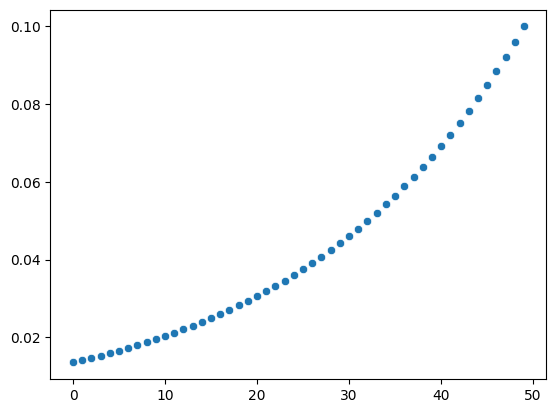

In [38]:
x_raw = np.linspace(28,40,50)
x = ( x_raw - x_raw.min() ) / ( x_raw.max() - x_raw.min() )
sns.scatterplot(np.exp(2*x) / np.exp(2*1) * 0.1)

#### Mutation probability rate

<Axes: >

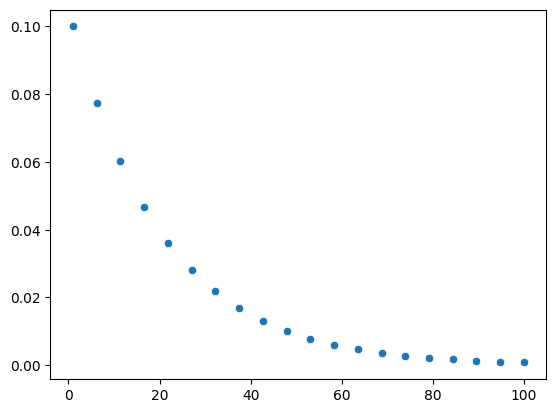

In [41]:
x = np.linspace(1,100,20)
sns.scatterplot(x=x, y=( (1 / np.power(1.05, x)) / ( 1 / np.power(1.05, 1)) ) * 0.1 )

In [88]:
np.asarray(list(map(lambda x: x["k_fa_max"], population))).mean()

1.4829589815728434

#### K burnup symmetry

In [ ]:
x = np.linspace(0,70, 100)

In [ ]:
sns.scatterplot(x=x, y=np.power(1.02, 0) / np.power(1.02, x))
sns.scatterplot(x=x, y=np.power(1.03, 0) / np.power(1.03, x))

In [ ]:
sns.scatterplot(x=x, y=np.power(1.04, 0) / np.power(1.04, x))

In [ ]:
sns.scatterplot(x=x, y=np.power(1.05, 0) / np.power(1.05, x))

#### K sym / k quarter

In [29]:
x = np.linspace(0, 1, 50)

<Axes: >

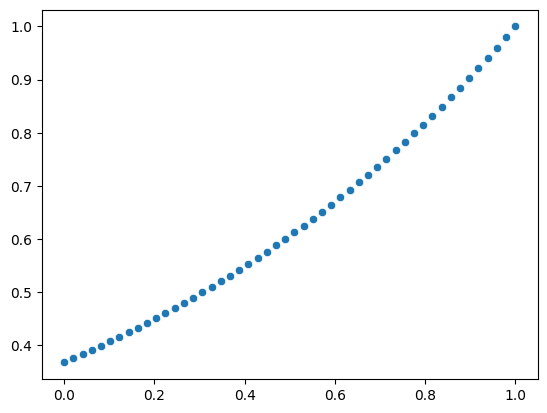

In [31]:
sns.scatterplot(x=x, y=np.exp((x - 1)) ) # / np.exp(1))

#### K fa max
#### rapid decreasing after limit exceeded

In [222]:
x_lim = 1.2
x = np.linspace(1.2, 2, 50)

In [223]:
y = x.copy()
# pos, val
stage = [None, None]
for i in range(len(x)):
    if x[i] <= 1.5:
        y[i] = 1 / ( x[i]/x_lim )
        continue
    elif stage[0] is None:
        print("assigning")
        stage[0] = x[i-1]
        stage[1] = y[i-1]
    y[i] = stage[1] * np.exp(-5* x[i] ) / np.exp ( -5* stage[0] )


assigning


<Axes: >

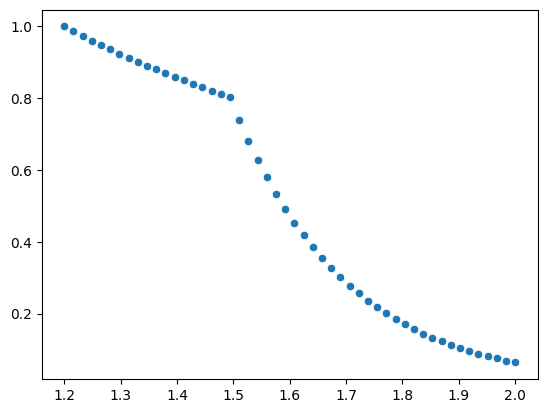

In [224]:
sns.scatterplot(x=x, y=y)

<Axes: >

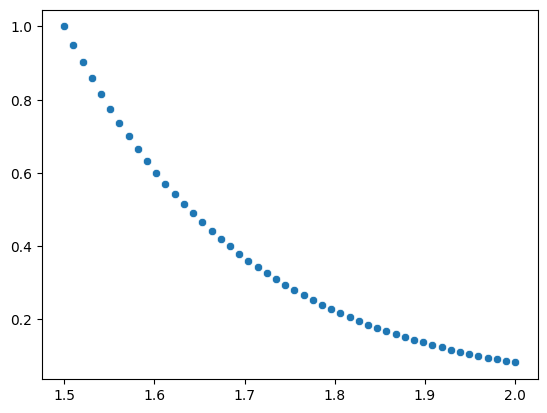

In [227]:
x_lim = 1.5
x = np.linspace(1.5, 2, 50)

sns.scatterplot(x=x, y=np.exp(-5*x) / np.exp(-5*x_lim))